In [4]:
%%capture
!pip install -q transformers datasets

In [5]:
# Verify GPU availability
import torch
print(f"Number of GPUs available: {torch.cuda.device_count()}")

Number of GPUs available: 2


# Load dataset

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
import datasets
from sklearn.model_selection import train_test_split

In [7]:
from logging import error
# Read dataset from csv file
def read_dataset(filepath):
    """
    Reads a CSV file into a pandas DataFrame.

    Args:
        filepath (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded dataset.
    """
    dataset = pd.read_csv(filepath, on_bad_lines='skip')
    return dataset

def convert_labels_to_one_hot(dataset, label_column, separator=';'):
    """
    Converts a multi-label string column into one-hot encoded format.

    Args:
        dataset (pd.DataFrame): The dataset containing a multi-label column.
        label_column (str): Name of the label column.
        separator (str): Separator used between labels in the string.

    Returns:
        pd.DataFrame: One-hot encoded labels as a DataFrame.
        MultiLabelBinarizer: The fitted binarizer for inverse transformations if needed.
    """
    # Ensure all values are strings, replace NaN with an empty string
    dataset[label_column] = dataset[label_column].astype(str).fillna('')

    # Split the labels by separator and strip whitespace
    labels_list = dataset[label_column].apply(lambda x: [label.strip() for label in x.split(separator) if label.strip()])

    # Initialize and fit MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(labels_list)

    # Create DataFrame for one-hot labels
    one_hot_df = pd.DataFrame(one_hot_labels, columns=mlb.classes_)

    return one_hot_df, mlb, labels_list

In [8]:
# Read the three datasets
train_df = pd.read_csv("/kaggle/input/resumedata/train.csv")
val_df = pd.read_csv("/kaggle/input/resumedata/val.csv")
test_df = pd.read_csv("/kaggle/input/resumedata/test.csv")
train_df.head()

,file_id,text,label
0,1,Database Administrator Database Administrator ...,Database_Administrator
1,2,Database Administrator Database Administrator ...,Database_Administrator
2,3,Oracle Database Administrator Oracle Database ...,Database_Administrator
3,4,"Amazon Redshift Administrator ETL Developer, B...",Database_Administrator
4,5,Scrum Master Scrum Master Scrum Master Richmon...,Database_Administrator


In [9]:
# nan_rows = train_df[val_df["label"].isna()]
# print(nan_rows)

import re

# Define valid job titles
valid_labels = {
    'Database_Administrator', 'Front_End_Developer', 'Java_Developer',
    'Network_Administrator', 'Project_manager', 'Python_Developer',
    'Security_Analyst', 'Software_Developer', 'Systems_Administrator',
    'Web_Developer'
}

# Function to check if a label is valid
def is_invalid_label(label_string):
    if not isinstance(label_string, str):
        return True  # If not a string, it's invalid

    labels = label_string.split(";")  # Split by semicolon
    return any(label.strip() not in valid_labels for label in labels)  # Check each label

# Find rows where labels are incorrectly formatted or contain invalid labels
invalid_rows = train_df[train_df["label"].apply(is_invalid_label)]

# Print the invalid rows
print(invalid_rows)

Empty DataFrame
Columns: [file_id, text, label]
Index: []


In [10]:
# Convert labels to one-hot encoding (assuming convert_labels_to_one_hot is defined)
train_one_hot, mlb, labels_list = convert_labels_to_one_hot(train_df, "label")
val_one_hot, mlb, labels_list = convert_labels_to_one_hot(val_df, "label")
test_one_hot, mlb, labels_list = convert_labels_to_one_hot(test_df, "label")

# Combine text with one-hot labels
train_df = pd.concat([train_df[["text"]].reset_index(drop=True), train_one_hot], axis=1)
val_df = pd.concat([val_df[["text"]].reset_index(drop=True), val_one_hot], axis=1)
test_df = pd.concat([test_df[["text"]].reset_index(drop=True), test_one_hot], axis=1)
train_df.head()

,text,Database_Administrator,Front_End_Developer,Java_Developer,Network_Administrator,Project_manager,Python_Developer,Security_Analyst,Software_Developer,Systems_Administrator,Web_Developer
0,Database Administrator Database Administrator ...,1,0,0,0,0,0,0,0,0,0
1,Database Administrator Database Administrator ...,1,0,0,0,0,0,0,0,0,0
2,Oracle Database Administrator Oracle Database ...,1,0,0,0,0,0,0,0,0,0
3,"Amazon Redshift Administrator ETL Developer, B...",1,0,0,0,0,0,0,0,0,0
4,Scrum Master Scrum Master Scrum Master Richmon...,1,0,0,0,0,0,0,0,0,0


In [11]:
# Convert pandas DataFrames to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Remove unnecessary columns if present
for dataset in [train_dataset, val_dataset, test_dataset]:
    if "__index_level_0__" in dataset.column_names:
        dataset = dataset.remove_columns(["__index_level_0__"])

In [12]:
# Create dataset dictionary
dataset = DatasetDict({
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
})

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'Database_Administrator', 'Front_End_Developer', 'Java_Developer', 'Network_Administrator', 'Project_manager', 'Python_Developer', 'Security_Analyst', 'Software_Developer', 'Systems_Administrator', 'Web_Developer'],
        num_rows: 22615
    })
    val: Dataset({
        features: ['text', 'Database_Administrator', 'Front_End_Developer', 'Java_Developer', 'Network_Administrator', 'Project_manager', 'Python_Developer', 'Security_Analyst', 'Software_Developer', 'Systems_Administrator', 'Web_Developer'],
        num_rows: 2855
    })
    test: Dataset({
        features: ['text', 'Database_Administrator', 'Front_End_Developer', 'Java_Developer', 'Network_Administrator', 'Project_manager', 'Python_Developer', 'Security_Analyst', 'Software_Developer', 'Systems_Administrator', 'Web_Developer'],
        num_rows: 2825
    })
})

# Preprocess Data

In [14]:
labels = ['Database_Administrator', 'Front_End_Developer', 'Java_Developer', 'Network_Administrator', 'Project_manager', 'Python_Developer', 'Security_Analyst', 'Software_Developer', 'Systems_Administrator', 'Web_Developer']
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [15]:
# Load Longformer tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")

def preprocess_data(examples):
    # Take a batch of texts
    text = examples["text"]

    # Encode them using Longformer tokenizer
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=1024)  # Adjust max_length if needed

    # Add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}

    # Create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))

    # Fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [16]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/22615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2855 [00:00<?, ? examples/s]

Map:   0%|          | 0/2825 [00:00<?, ? examples/s]

In [17]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [18]:
tokenizer.decode(example['input_ids'])

"<s>Database Administrator Database Administrator Database Administrator - Family Private Care LLC Lawrenceville, GA self-motivated Production SQL Server Database Administrator possesses strong analytical problem solving skills. experience includes SQL Server 2005, 2008 2012, 2014, SSIS, well clustering, mirroring, high availability solutions OLTP environments. proficient database backup, recovery, performance tuning, maintenance tasks, security, consolidation. confident would make beneficial addition company. course career thus far, designed databases fit variety needs, successfully ensured security databases, problem-solved order meet back-end front-end needs, installed tested new versions database management systems, customized installed applications meticulously monitored performance smoothest front-end experience possible. 5 6 years working databases. Work Experience Database Administrator Family Private Care LLC - Roswell, GA April 2017 Present Confirm backups made successfully s

In [19]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['Database_Administrator']

In [20]:
encoded_dataset.set_format("torch")

# Model

In [21]:
# "allenai/longformer-large-4096"
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("allenai/longformer-base-4096",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

2025-05-16 10:08:26.134691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747390106.342975      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747390106.403700      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

In [23]:
# save model as pt
# model.save_pretrained("longformer")

# Train

In [24]:
batch_size = 4
metric_name = "f1"

In [25]:
import torch

label_tensor = torch.tensor(train_df[['Database_Administrator', 'Front_End_Developer', 'Java_Developer', 'Network_Administrator', 'Project_manager', 'Python_Developer', 'Security_Analyst', 'Software_Developer', 'Systems_Administrator', 'Web_Developer']].values)
# Count the number of positive samples per class
pos_counts = label_tensor.sum(dim=0)

# Count the number of negative samples per class
neg_counts = label_tensor.shape[0] - pos_counts

# Compute pos_weight = (Negative Samples / Positive Samples)
pos_weight = neg_counts / (pos_counts + 1e-6)  # Avoid division by zero

print("Computed pos_weight:", pos_weight)

# Convert to tensor and detach
pos_weight_tensor = pos_weight.clone().detach()

model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

Computed pos_weight: tensor([7.6981, 6.2461, 8.0171, 5.7387, 5.2872, 9.1458, 8.5181, 0.9360, 3.9813,
        3.4694])


In [26]:
from transformers import Trainer, TrainingArguments
import torch.nn as nn

class CustomTrainer(Trainer):
    def __init__(self, *args, pos_weight=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight  # Store precomputed pos_weight

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=batch_size): # Add num_items_in_batch
        labels = inputs.pop("labels")  # Extract labels
        outputs = model(**inputs)
        logits = outputs.logits  # Get model logits

        # Define BCEWithLogitsLoss with pos_weight
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fn(logits, labels.float())  # Ensure labels are float

        return (loss, outputs) if return_outputs else loss

In [27]:
from transformers import TrainerCallback
import time

class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.epoch_start_time = None

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_duration = time.time() - self.epoch_start_time
        minutes, seconds = divmod(epoch_duration, 60)
        # Search log_history for train and eval losses
        train_loss = None
        eval_loss = None
        for log in reversed(state.log_history):
            if 'loss' in log and train_loss is None:
                train_loss = log['loss']
            if 'eval_loss' in log and eval_loss is None:
                eval_loss = log['eval_loss']
            if train_loss is not None and eval_loss is not None:
                break
        print(f"Epoch {state.epoch}:")
        print(f"  Duration = {int(minutes)}m {seconds:.2f}s")

In [28]:
# Training Arguments
args = TrainingArguments(
    output_dir="/kaggle/working/longformer",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    metric_for_best_model=metric_name,
    report_to="none",
    save_total_limit=None,  # Save all checkpoints
    logging_strategy="epoch",  # Log at end of each epoch
    ddp_find_unused_parameters=False,  # Optimize DDP for Transformers
    dataloader_num_workers=2,  # Improve data loading with multiple workers
    fp16=True  # Enable mixed precision for faster training
)

In [29]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [30]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [31]:
encoded_dataset['train']['input_ids'][0].size()

torch.Size([1024])

In [32]:
# Test forward pass on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

In [33]:
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0).to(device),
                labels=encoded_dataset['train'][0]['labels'].unsqueeze(0).to(device))
outputs

Initializing global attention on CLS token...


LongformerSequenceClassifierOutput(loss=tensor(0.7343, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.0337,  0.1860, -0.0042,  0.0469,  0.1045,  0.1572,  0.1307,  0.0874,
         -0.0465,  0.1637]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None, global_attentions=None)

In [34]:
# Initialize Trainer
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    pos_weight=pos_weight_tensor,
    callbacks=[LossLoggingCallback()]
)

/tmp/ipykernel_35/3689408077.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [35]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.309200,0.206269,0.919943,0.959292,0.766375
2,0.190400,0.191933,0.937867,0.966216,0.821016
3,0.160300,0.182780,0.941482,0.968756,0.834326
4,0.149500,0.205216,0.944804,0.969241,0.844483
5,0.131800,0.219497,0.946493,0.969930,0.847986


Epoch 1.0:
  Duration = 98m 4.13s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2.0:
  Duration = 97m 36.93s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3.0:
  Duration = 97m 22.54s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4.0:
  Duration = 97m 46.22s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5.0:
  Duration = 97m 30.67s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TrainOutput(global_step=14135, training_loss=0.1882244832025723, metrics={'train_runtime': 31167.8518, 'train_samples_per_second': 3.628, 'train_steps_per_second': 0.454, 'total_flos': 7.42777699832832e+16, 'train_loss': 0.1882244832025723, 'epoch': 5.0})

# Evaluate

In [36]:
trainer.evaluate(encoded_dataset["test"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'eval_loss': 0.20844696462154388,
 'eval_f1': 0.9482525584089593,
 'eval_roc_auc': 0.9714400353341038,
 'eval_accuracy': 0.8534513274336283,
 'eval_runtime': 366.2485,
 'eval_samples_per_second': 7.713,
 'eval_steps_per_second': 0.967,
 'epoch': 5.0}

# Inference

In [40]:
text = "I have 3 years experience in working with Python and write softwares for customers."

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to("cuda" if torch.cuda.is_available() else "cpu") for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [41]:
logits = outputs.logits
logits.shape

torch.Size([1, 10])

In [42]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['Python_Developer', 'Software_Developer']


# Loss History

In [43]:
import pandas as pd

# Extract loss history from trainer.state.log_history
loss_history = []
current_epoch = None
epoch_data = {}
last_train_loss = None

for log in trainer.state.log_history:
    epoch = log.get('epoch')
    # Check for epoch-end evaluation log
    if 'eval_loss' in log and epoch == int(epoch):
        # Save previous epoch's data
        if epoch_data:
            epoch_data['train_loss'] = last_train_loss
            loss_history.append(epoch_data)
        # Start new epoch data
        epoch_data = {'epoch': int(epoch)}
        epoch_data['eval_loss'] = log['eval_loss']
    # Update training loss if present
    if 'loss' in log:
        last_train_loss = log['loss']

# Append the last epoch's data
if epoch_data and last_train_loss is not None:
    epoch_data['train_loss'] = last_train_loss
    loss_history.append(epoch_data)

# Convert to DataFrame
loss_df = pd.DataFrame(loss_history)

# Save to CSV
loss_df.to_csv('/kaggle/working/loss_history.csv', index=False)
print("Loss history saved to /kaggle/working/loss_history.csv")

# Display the DataFrame
loss_df

Loss history saved to /kaggle/working/loss_history.csv


,epoch,eval_loss,train_loss
0,1,0.206269,0.1904
1,2,0.191933,0.1603
2,3,0.182780,0.1495
3,4,0.205216,0.1318
4,5,0.219497,0.1318
5,5,0.208447,0.1318


# ZIP file

In [44]:
import zipfile
import os
from pathlib import Path

# Define paths
output_dir = '/kaggle/working'
zip_path = '/kaggle/working/longformer.zip'

# Create a ZIP file
def zip_directory(directory, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(root, file)
                # Store relative path in ZIP
                arcname = os.path.relpath(file_path, start=output_dir)
                zipf.write(file_path, arcname)
                print(f"Added {arcname} to ZIP")

# Zip /kaggle/working/
try:
    zip_directory(output_dir, zip_path)
    print(f"\nZIP file created at {zip_path}")
    print(f"Size: {os.path.getsize(zip_path) / (1024*1024):.2f} MB")
except Exception as e:
    print(f"Error creating ZIP: {e}")

# Verify ZIP contents
with zipfile.ZipFile(zip_path, 'r') as zipf:
    print("\nContents of ZIP:")
    for file in zipf.namelist():
        print(file)

Added loss_history.csv to ZIP
Added longformer.zip to ZIP
Added longformer/checkpoint-11308/rng_state.pth to ZIP
Added longformer/checkpoint-11308/training_args.bin to ZIP
Added longformer/checkpoint-11308/merges.txt to ZIP
Added longformer/checkpoint-11308/tokenizer.json to ZIP
Added longformer/checkpoint-11308/model.safetensors to ZIP
Added longformer/checkpoint-11308/tokenizer_config.json to ZIP
Added longformer/checkpoint-11308/config.json to ZIP
Added longformer/checkpoint-11308/scaler.pt to ZIP
Added longformer/checkpoint-11308/trainer_state.json to ZIP
Added longformer/checkpoint-11308/optimizer.pt to ZIP
Added longformer/checkpoint-11308/vocab.json to ZIP
Added longformer/checkpoint-11308/special_tokens_map.json to ZIP
Added longformer/checkpoint-11308/scheduler.pt to ZIP
Added longformer/checkpoint-2827/rng_state.pth to ZIP
Added longformer/checkpoint-2827/training_args.bin to ZIP
Added longformer/checkpoint-2827/merges.txt to ZIP
Added longformer/checkpoint-2827/tokenizer.jso

# Visualize Result

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [2]:
# Import libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import torch
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import json
from transformers.integrations import WandbCallback



# Set model directory path
model_dir = "/kaggle/input/checkpoint-8481"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define trainer
trainer = Trainer(model=model, tokenizer=tokenizer)
trainer.remove_callback(WandbCallback)

2025-05-17 04:50:40.852965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747457441.027128      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747457441.079784      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_35/2555566245.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [3]:
# Load datasets (train, validation, and test)
train_df = pd.read_csv("/kaggle/input/resumedata/train.csv")
val_df = pd.read_csv("/kaggle/input/resumedata/val.csv")
test_df = pd.read_csv("/kaggle/input/resumedata/test.csv")

# One-hot labels conversion
def convert_labels_to_one_hot(dataset, label_column, separator=';'):
    labels_list = dataset[label_column].apply(lambda x: [label.strip() for label in x.split(separator)])
    mlb = MultiLabelBinarizer()
    one_hot_labels = mlb.fit_transform(labels_list)
    one_hot_df = pd.DataFrame(one_hot_labels, columns=mlb.classes_)
    return one_hot_df, mlb, labels_list

one_hot_train, mlb, _ = convert_labels_to_one_hot(train_df, "label")
one_hot_val, _, _ = convert_labels_to_one_hot(val_df, "label")
one_hot_test, _, _ = convert_labels_to_one_hot(test_df, "label")

# Combine text with one-hot labels
train_df = pd.concat([train_df[["text"]].reset_index(drop=True), one_hot_train], axis=1)
val_df = pd.concat([val_df[["text"]].reset_index(drop=True), one_hot_val], axis=1)
test_df = pd.concat([test_df[["text"]].reset_index(drop=True), one_hot_test], axis=1)


In [4]:
# Convert pandas DataFrame to HuggingFace dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Get list of labels
labels = mlb.classes_.tolist()

# Preprocessing function for encoding text and labels
def preprocess_data(examples):
    text = examples["text"]
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=1024)
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    labels_matrix = np.zeros((len(text), len(labels)))
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]
    encoding["labels"] = labels_matrix.tolist()
    return encoding

# Encode the datasets
encoded_train_dataset = train_dataset.map(preprocess_data, batched=True, remove_columns=train_dataset.column_names)
encoded_val_dataset = val_dataset.map(preprocess_data, batched=True, remove_columns=val_dataset.column_names)
encoded_test_dataset = test_dataset.map(preprocess_data, batched=True, remove_columns=test_dataset.column_names)

encoded_train_dataset.set_format("torch")
encoded_val_dataset.set_format("torch")
encoded_test_dataset.set_format("torch")


Map:   0%|          | 0/22615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2855 [00:00<?, ? examples/s]

Map:   0%|          | 0/2825 [00:00<?, ? examples/s]

## Classification Report

In [5]:
# Function to get classification report
def get_classification_report(trainer, dataset, label_names=labels, threshold=0.5):
    # Predict
    predictions_output = trainer.predict(dataset)
    preds = predictions_output.predictions
    labels_true = predictions_output.label_ids

    # Apply sigmoid + threshold
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(preds))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    # Classification report for each label
    report = classification_report(labels_true, y_pred, target_names=label_names)
    print("Classification Report (Test Set):\n")
    print(report)
    return report

# Get classification report on test set
classification_report_test = get_classification_report(trainer, encoded_test_dataset)


Initializing global attention on CLS token...
Initializing global attention on CLS token...
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Classification Report (Test Set):

                        precision    recall  f1-score   support

Database_Administrator       0.94      0.96      0.95       325
   Front_End_Developer       0.97      0.95      0.96       390
        Java_Developer       0.90      0.93      0.91       313
 Network_Administrator       0.93      0.93      0.93       420
       Project_manager       0.89      0.92      0.91       450
      Python_Developer       0.93      0.97      0.95       279
      Security_Analyst       0.93      0.98      0.95       297
    Software_Developer       0.98      0.99      0.98      1460
 Systems_Administrator       0.96      0.95      0.96       568
         Web_Developer       0.83      0.93      0.88       633

             micro avg       0.93      0.96      0.95      5135
             macro avg       0.93      0.95      0.94      5135
          weighted avg       0.94      0.96      0.95      5135
           samples avg       0.95      0.97      0.95      5135



## ROC Curve

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


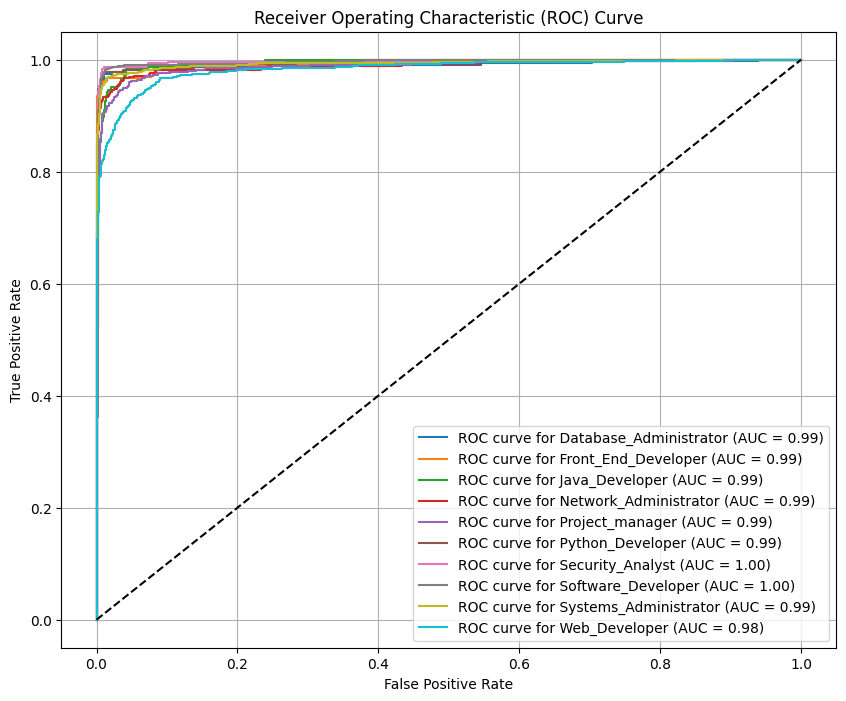

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import torch
import numpy as np
import matplotlib.pyplot as plt

# Get predictions (probabilities) from the model
predictions_output = trainer.predict(encoded_test_dataset)  # Ensure you have the predictions

# Get the raw model outputs (logits)
preds = predictions_output.predictions
labels_true = predictions_output.label_ids

# Apply sigmoid to get probabilities
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(preds))

# No need to use LabelBinarizer since labels_true is already in binary format
# labels_true_bin = lb.transform(labels_true) # This line is removed

# Calculate ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(labels)):
    # Use labels_true directly instead of labels_true_bin
    fpr[i], tpr[i], _ = roc_curve(labels_true[:, i], probs[:, i].detach().cpu().numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {labels[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Customize plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Training and Validation Loss per Epoch

dict_keys(['best_global_step', 'best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params'])
Train Losses: [0.3092, 0.1904, 0.1603]
Val Losses: [0.20626913011074066, 0.19193343818187714, 0.18278008699417114]


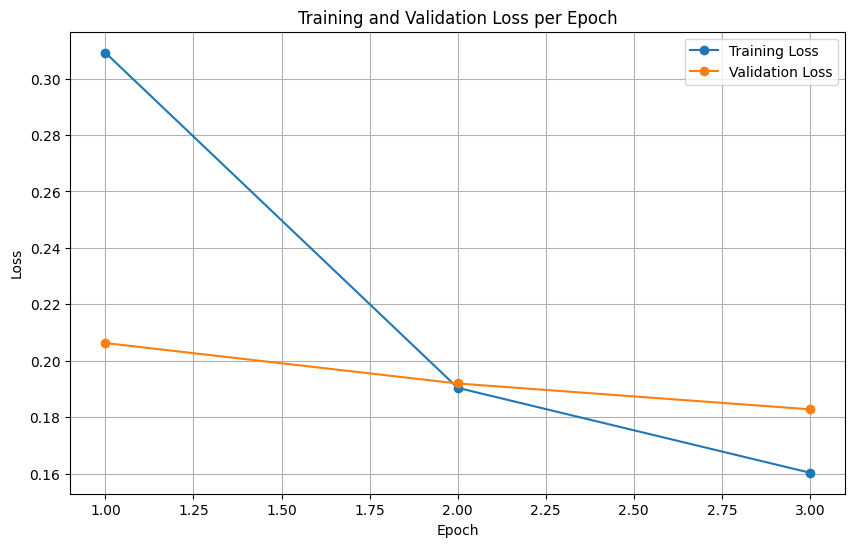

In [8]:
# Load trainer state data
trainer_state_file = "/kaggle/input/checkpoint-8481/trainer_state.json"
with open(trainer_state_file, "r") as f:
    trainer_state_data = json.load(f)

# Check keys in trainer_state_data
print(trainer_state_data.keys())

# Get log history for losses
log_history = trainer_state_data["log_history"]

train_loss = []
val_loss = []
epochs_train = []
epochs_val = []

for log in log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
        epochs_train.append(log['epoch'])
    if 'eval_loss' in log:
        val_loss.append(log['eval_loss'])
        epochs_val.append(log['epoch'])

# Print training and validation losses
print("Train Losses:", train_loss)
print("Val Losses:", val_loss)

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs_train, train_loss, label="Training Loss", marker='o')
plt.plot(epochs_val, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()
